![women_clothing](clothing.jpg)

Welcome to the world of e-commerce, where customer feedback is a goldmine of insights! In this project, you'll dive into the Women's Clothing E-Commerce Reviews dataset, focusing on the 'Review Text' column filled with direct customer opinions.

Your mission is to use text embeddings and Python to analyze these reviews, uncover underlying themes, and understand customer sentiments. This analysis will help improve customer service and product offerings.

## The Data

You will be working with a dataset specifically focusing on customer reviews. Below is the data dictionary for the relevant field:

## womens_clothing_e-commerce_reviews.csv

| Column        | Description                           |
|---------------|---------------------------------------|
| `'Review Text'` | Textual feedback provided by customers about their shopping experience and product quality. |

Armed with access to powerful embedding API services, you will process the reviews, extract meaningful insights, and present your findings.

Let's get started!



## Load OpenAI API key from environment variables
These variables can be referenced globally throughout the project while keeping their values secret. Good for setting passwords in credentials.

In [38]:
# Initialize your API key
import os
openai_api_key = os.environ["OPENAI"]

## Install useful libraries

In [39]:
# Update OpenAI to 1.3
from importlib.metadata import version
try:
    assert version('openai') == '1.3.0'
except:
    !pip install openai==1.3.0
import openai

In [ ]:
# Run this cell to install ChromaDB if desired
try:
    assert version('chromadb') == '0.4.17'
except:
    !pip install chromadb==0.4.17
try:
    assert version('pysqlite3') == '0.5.2'
except:
    !pip install pysqlite3-binary==0.5.2
__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')

import chromadb

## Load the dataset
Load data and perform basic data checks to ensure you are using relevant data for the analysis

In [41]:
# Load the dataset
import pandas as pd
reviews = pd.read_csv("womens_clothing_e-commerce_reviews.csv")

# Display the first few entries
reviews.head()

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


## Create and store embeddings
Embed the reviews using a suitable text embedding algorithm and store them as list in the variable ```embeddings```.

In [42]:
review_texts = reviews['Review Text'].dropna().tolist()

# Create and store embeddings
client = openai.OpenAI(api_key=openai_api_key)
model = "text-embedding-ada-002"

responses = client.embeddings.create(
model = model,
input = review_texts)

response_dict = responses.model_dump()

review_embeddings = [response['embedding'] for response in response_dict['data']]

## Dimesionality reduction & Visualization
Apply an appropriate dimensionalty reduction technique to reduce the ```embeddings``` to a 2-dimensional numpy array. Then use this variable tp plot a visual representation of the reviews.

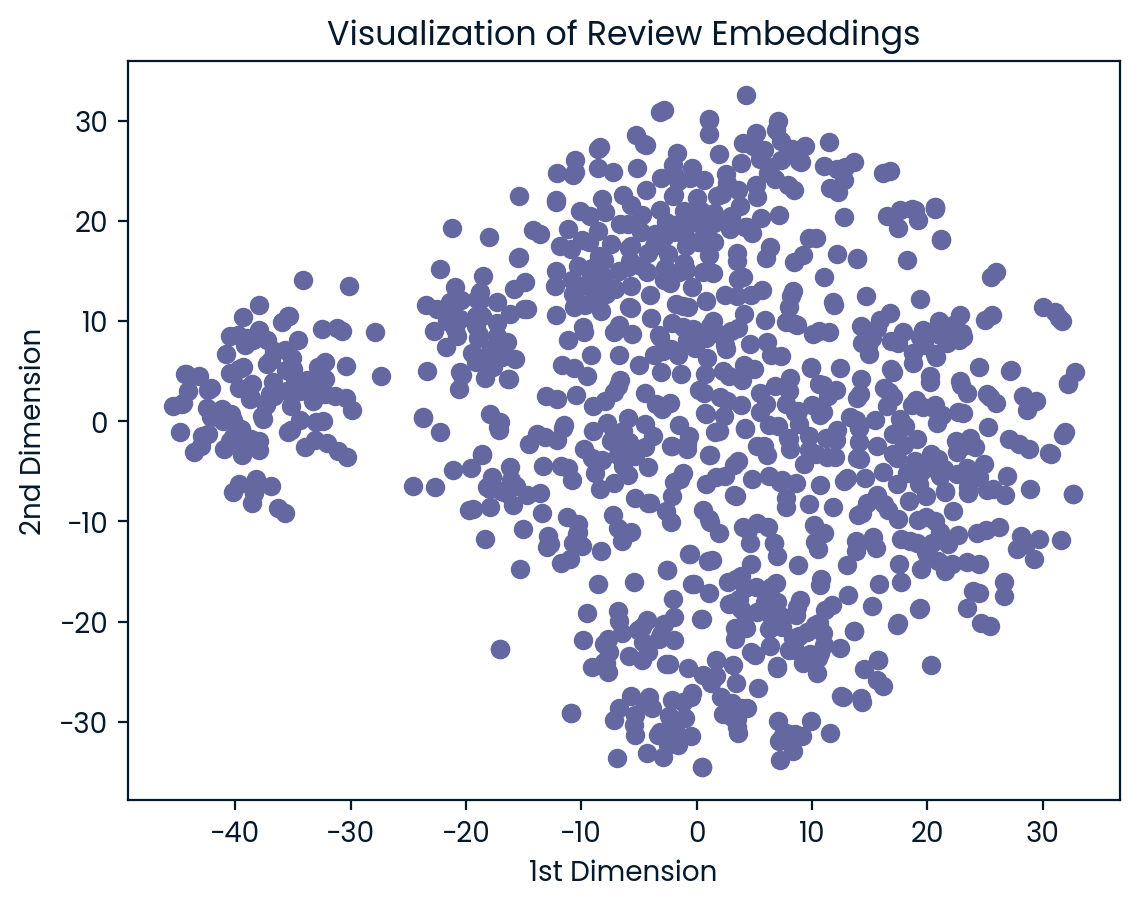

In [43]:
from sklearn.manifold import TSNE
import numpy as np

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(np.array(review_embeddings))

# Plotting the visual representation of the reviews
import matplotlib.pyplot as plt

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.title("Visualization of Review Embeddings")
plt.xlabel("1st Dimension")
plt.ylabel("2nd Dimension")
plt.show()

## Feedback categorization
Use embeddings to identify some reviews that discuss topics such as 'quality', 'fit', 'style' and 'comfort'.

In [44]:
from scipy.spatial import distance

# Create feedback categories
categories = ['quality', 'fit', 'style', 'comfort']

cat_responses = client.embeddings.create(input=categories, model=model)
cat_res_dict = cat_responses.model_dump()
category_embeddings = [response['embedding'] for response in cat_res_dict['data']]

# Function to categorize feedback
def categorize(query_vector, embeddings):
    distances = []
    for index, embedding in enumerate(embeddings):
        dist = distance.cosine(query_vector, embedding)
        distances.append({'distance' : dist, 'index': index})
    closest_cat = min(distances, key=lambda x: x['distance'])
    return categories[closest_cat['index']]

# Label reviews
review_cats = [categorize(query, category_embeddings) for query in review_embeddings]

In [45]:
# Create DataFrame with reviews and categories
categorized_reviews = pd.DataFrame(reviews['Review Text'].dropna())
categorized_reviews['Category'] = [category for category in review_cats]
categorized_reviews.head()

,Review Text,Category
0,Absolutely wonderful - silky and sexy and comf...,fit
1,Love this dress! it's sooo pretty. i happene...,fit
2,I had such high hopes for this dress and reall...,fit
3,"I love, love, love this jumpsuit. it's fun, fl...",fit
4,This shirt is very flattering to all due to th...,fit


## Similarity search function
Write a function that outputs the closest 3 reviews to a given input review, enabling more personalized service response. Apply the function to the first review of the dataset and store the output as a list in the variable ```most_similar_reviews```

In [46]:
import chromadb
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

# Initialize Chromadb database for vector storage
client = chromadb.PersistentClient()
client.delete_collection(name="review_embeddings") # clear database, if already in use

review_database = client.create_collection(
    name="review_embeddings",
    embedding_function=OpenAIEmbeddingFunction(api_key=openai_api_key)
)

review_database.add(
    documents=review_texts, 
    ids=[str(i) for i in range(len(review_texts))]
)

# Similarity search function
def find_similar_reviews(input_review, database=review_database, n=3):
    data = client.get_collection(
        name="review_embeddings", 
        embedding_function=OpenAIEmbeddingFunction(api_key=openai_api_key))
    similar_reviews = data.query(query_texts = [input_review], n_results = n)
    return similar_reviews

# Example
example = reviews.at[0, 'Review Text']
most_similar_reviews = find_similar_reviews(example)['documents'][0]
print(most_similar_reviews)

['Absolutely wonderful - silky and sexy and comfortable', 'Very comfortable and versatile. got lots of compliments.', 'Loved this top. great design. comfortable and unique. soft material']
